In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report,precision_score,recall_score,f1_score,confusion_matrix
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer

import torch
from torch.utils.data import DataLoader,Dataset

In [3]:
ttrain = pd.read_csv('tam_training_data_hum_ai.csv')
ttest = pd.read_excel('tam_test_data_hum_ai.xlsx')

## Dataset Info

In [4]:
ttrain.shape, ttest.shape

((808, 3), (100, 2))

In [5]:
ttrain.isnull().sum(), ttest.isnull().sum()

(ID       0
 DATA     0
 LABEL    0
 dtype: int64,
 ID      0
 DATA    0
 dtype: int64)

In [6]:
ttrain.info(), ttest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      808 non-null    object
 1   DATA    808 non-null    object
 2   LABEL   808 non-null    object
dtypes: object(3)
memory usage: 19.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      100 non-null    object
 1   DATA    100 non-null    object
dtypes: object(2)
memory usage: 1.7+ KB


(None, None)

In [7]:
ttrain.head()

,ID,DATA,LABEL
0,TAM_HUAI_TR_001,இந்த சோப்பின் மணம் மிகவும் புத்துணர்ச்சியூட்டு...,AI
1,TAM_HUAI_TR_002,தோலை நன்கு சுத்தம் செய்ய இது மிகவும் சிறப்பானது.,AI
2,TAM_HUAI_TR_003,"இதைப் பயன்படுத்திய பிறகு, தோல் மிக மென்மையாக உ...",AI
3,TAM_HUAI_TR_004,இந்த சோப்பில் இயற்கையான மூலப்பொருட்கள் பயன்படு...,AI
4,TAM_HUAI_TR_005,"சிறிது சோப்பு போதும், அதிக நுரை உருவாகிறது.",AI


In [8]:
ttest.head()

,ID,DATA
0,TAM_HUAI_TE_001,நான் அண்மையில் வாங்கிய ஒரு வாட்டர் பாட்டில் ம...
1,TAM_HUAI_TE_002,அணிவதற்கு நன்றாக இருக்கும்
2,TAM_HUAI_TE_003,அதிக வாசனை வாந்தி
3,TAM_HUAI_TE_004,அதிகமக பயன்பதுதினல் தலை சுட்ரும்
4,TAM_HUAI_TE_005,அழகாக இருக்கும்


In [9]:
ttrain['count'] = ttrain['DATA'].apply(lambda x: len(x.split()))
ttest['count'] = ttest['DATA'].apply(lambda x: len(x.split()))

In [10]:
ttrain['LABEL'].value_counts()

,count
LABEL,
AI,405
HUMAN,403


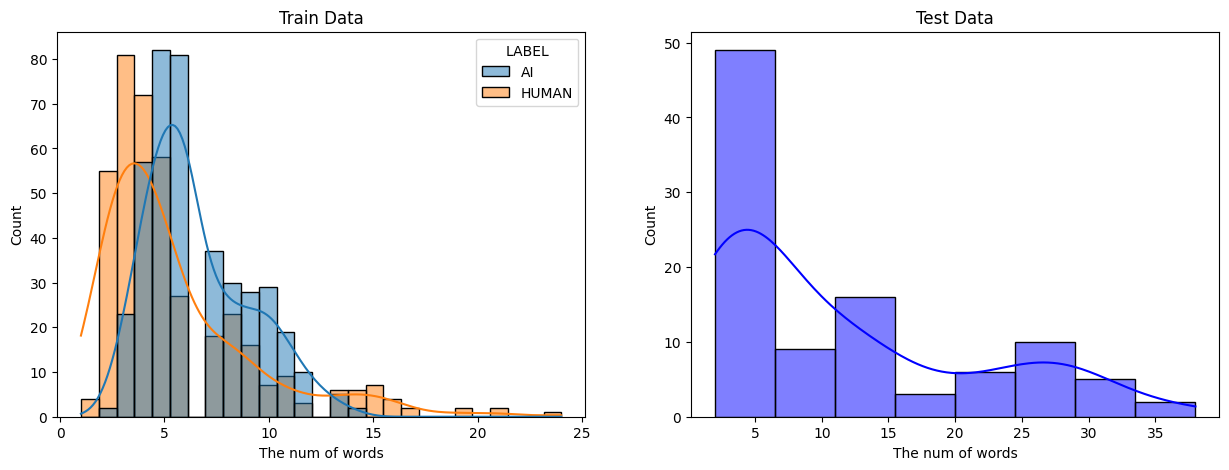

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(ttrain, x='count', hue='LABEL', ax=axes[0], color="blue", kde=True)
axes[0].set_xlabel("The num of words")
axes[0].set_ylabel("Count")
axes[0].set_title("Train Data")

sns.histplot(ttest['count'], ax=axes[1], color="blue", kde=True)
axes[1].set_xlabel("The num of words")
axes[1].set_ylabel("Count")
axes[1].set_title("Test Data")

plt.show()

## Preprocessing

In [12]:
import re

def preprocess(text):
    text = re.sub(r'[😀-🙿]',' ',text)
    text = re.sub(r'\s+',' ',text)
    text = re.sub(r'<[^>]*>',' ',text)
    text = re.sub(r'http\S+|www\S+|https\S+',' ',text)
    text = re.sub(r'\([^)]*\)', ' ', text)
    text = re.sub(r'[^\u0B80-\u0BFFa-zA-Z0-9\s]',' ',text).strip()

    return text

In [13]:
ttrain['preprocess_data'] = ttrain['DATA'].apply(preprocess)
ttest['preprocess_data'] = ttest['DATA'].apply(preprocess)

ttrain['LabelValue'] = ttrain['LABEL'].apply(lambda x: 1 if x == 'HUMAN' else 0)

### train-test split

In [14]:
ttrain_data, tval_data = train_test_split(ttrain, test_size=0.2, random_state=42)

ttrain_data = ttrain_data.reset_index(drop=True)
tval_data = tval_data.reset_index(drop=True)

## Bag of words

In [15]:
v = CountVectorizer()

In [16]:
X_train = v.fit_transform(ttrain_data['preprocess_data'])
y_train = ttrain_data['LabelValue']

X_val = v.transform(tval_data['preprocess_data'])
y_val = tval_data['LabelValue']

In [17]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression()

In [18]:
y_pred = lr_model.predict(X_val)
accuracy_score(y_val, y_pred),precision_score(y_val, y_pred),recall_score(y_val, y_pred),f1_score(y_val, y_pred,average="macro")

(0.8518518518518519, 0.8170731707317073, 0.881578947368421, 0.8517614762848864)

In [19]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [20]:
y_pred = dt_model.predict(X_val)
accuracy_score(y_val, y_pred),precision_score(y_val, y_pred),recall_score(y_val, y_pred),f1_score(y_val, y_pred),f1_score(y_val, y_pred,average="macro")

(0.8580246913580247,
 0.8533333333333334,
 0.8421052631578947,
 0.847682119205298,
 0.8573670711633427)

In [21]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [22]:
y_pred = rf_model.predict(X_val)
accuracy_score(y_val, y_pred),precision_score(y_val, y_pred),recall_score(y_val, y_pred),f1_score(y_val, y_pred),f1_score(y_val, y_pred,average="macro")

(0.8827160493827161,
 0.8433734939759037,
 0.9210526315789473,
 0.8805031446540881,
 0.8826758147512865)

In [23]:
svm_model = SVC()
svm_model.fit(X_train, y_train)

SVC()

In [24]:
y_pred = svm_model.predict(X_val)
accuracy_score(y_val, y_pred),precision_score(y_val, y_pred),recall_score(y_val, y_pred),f1_score(y_val, y_pred),f1_score(y_val, y_pred,average="macro")

(0.8580246913580247,
 0.8441558441558441,
 0.8552631578947368,
 0.8496732026143791,
 0.8575851393188854)

In [25]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

In [26]:
y_pred = nb_model.predict(X_val)
accuracy_score(y_val, y_pred),precision_score(y_val, y_pred),recall_score(y_val, y_pred),f1_score(y_val, y_pred),f1_score(y_val, y_pred,average="macro")

(0.7962962962962963,
 0.8208955223880597,
 0.7236842105263158,
 0.7692307692307693,
 0.7934551636209095)

## Tf-IDF

In [27]:
vectorizer = TfidfVectorizer()

In [28]:
X_train = vectorizer.fit_transform(ttrain_data['preprocess_data'])
y_train = ttrain_data['LabelValue']

X_val = vectorizer.transform(tval_data['preprocess_data'])
y_val = tval_data['LabelValue']

In [29]:
final_results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

In [30]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression()

In [31]:
y_pred = lr_model.predict(X_val)
accuracy_score(y_val, y_pred),precision_score(y_val, y_pred),recall_score(y_val, y_pred),f1_score(y_val, y_pred),f1_score(y_val, y_pred,average="macro")

(0.8209876543209876,
 0.7901234567901234,
 0.8421052631578947,
 0.8152866242038217,
 0.8208169647965216)

In [32]:
print("Classification Report:\n",classification_report(y_val, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.80      0.83        86
           1       0.79      0.84      0.82        76

    accuracy                           0.82       162
   macro avg       0.82      0.82      0.82       162
weighted avg       0.82      0.82      0.82       162



In [33]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [34]:
y_pred = dt_model.predict(X_val)
accuracy_score(y_val, y_pred),precision_score(y_val, y_pred),recall_score(y_val, y_pred),f1_score(y_val, y_pred),f1_score(y_val, y_pred,average="macro")

(0.8271604938271605,
 0.8076923076923077,
 0.8289473684210527,
 0.8181818181818182,
 0.8267379679144385)

In [35]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [36]:
y_pred = rf_model.predict(X_val)
accuracy_score(y_val, y_pred),precision_score(y_val, y_pred),recall_score(y_val, y_pred),f1_score(y_val, y_pred),f1_score(y_val, y_pred,average="macro")

(0.8703703703703703,
 0.8873239436619719,
 0.8289473684210527,
 0.8571428571428571,
 0.8692493946731235)

In [37]:
svm_model = SVC()
svm_model.fit(X_train, y_train)

SVC()

In [38]:
y_pred = svm_model.predict(X_val)
accuracy_score(y_val, y_pred),precision_score(y_val, y_pred),recall_score(y_val, y_pred),f1_score(y_val, y_pred),f1_score(y_val, y_pred,average="macro")

(0.8765432098765432,
 0.8589743589743589,
 0.881578947368421,
 0.8701298701298701,
 0.8762414056531703)

In [39]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

In [40]:
y_pred = nb_model.predict(X_val)
accuracy_score(y_val, y_pred),precision_score(y_val, y_pred),recall_score(y_val, y_pred),f1_score(y_val, y_pred),f1_score(y_val, y_pred,average="macro")

(0.808641975308642,
 0.8260869565217391,
 0.75,
 0.7862068965517242,
 0.8065112695049124)

## Hugging Face Transformers


In [41]:
x_train = list(ttrain_data['preprocess_data'])
y_train = list(ttrain_data['LabelValue'])

x_val = list(tval_data['preprocess_data'])
y_val = list(tval_data['LabelValue'])

x_test = list(ttest['preprocess_data'])

In [42]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification
bert_model = "l3cube-pune/tamil-bert"
tokenizer = AutoTokenizer.from_pretrained(bert_model)
model = AutoModelForSequenceClassification.from_pretrained(bert_model,num_labels=2)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/6.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/951M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at l3cube-pune/tamil-bert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
train_encodings = tokenizer(x_train, truncation=True)
val_encodings = tokenizer(x_val, truncation=True)
test_encodings = tokenizer(x_test, truncation=True)

In [44]:
class tamilDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
          item['labels'] = torch.tensor(self.labels[idx])
        return item

In [45]:
train_dataset = tamilDataset(train_encodings,y_train)
val_dataset = tamilDataset(val_encodings,y_val)
test_dataset = tamilDataset(test_encodings,None)

In [46]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [47]:
training_args = TrainingArguments(
    output_dir='./t3results',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=15,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir='./t3logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    seed = 42
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [48]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "macro_f1": f1_score(labels, predictions, average="macro")
    }

In [49]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator = data_collator
)

In [50]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: psaisathvik612 (pss612) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Macro F1
1,0.687200,0.679420,0.790123,0.839415,0.790123,0.785251,0.786875
2,0.642600,0.613822,0.882716,0.883743,0.882716,0.882378,0.881702
3,0.575400,0.561539,0.876543,0.878073,0.876543,0.876087,0.875327
4,0.514800,0.509807,0.913580,0.913965,0.913580,0.913633,0.913369
5,0.471300,0.468556,0.925926,0.926299,0.925926,0.925971,0.925745
6,0.434100,0.460371,0.888889,0.896755,0.888889,0.887750,0.886801
7,0.390100,0.421481,0.907407,0.907399,0.907407,0.907368,0.906979
8,0.371200,0.399964,0.913580,0.915490,0.913580,0.913261,0.912729
9,0.334300,0.368326,0.932099,0.932541,0.932099,0.931997,0.931659
10,0.297400,0.342797,0.938272,0.939163,0.938272,0.938139,0.937807


TrainOutput(global_step=315, training_loss=0.4055747051087637, metrics={'train_runtime': 782.3612, 'train_samples_per_second': 12.386, 'train_steps_per_second': 0.403, 'total_flos': 129777472501200.0, 'train_loss': 0.4055747051087637, 'epoch': 15.0})

In [51]:
eval_results = trainer.evaluate()
print("accuracy_score", round(eval_results['eval_accuracy'], 2))
print("precision_score", round(eval_results['eval_precision'], 2))
print("recall_score", round(eval_results['eval_recall'], 2))
print("f1_score", round(eval_results['eval_f1'], 2))

final_results = pd.concat([final_results, pd.DataFrame([{'Model': 'Tamil Bert', 'Accuracy':eval_results['eval_accuracy'], 'Precision': eval_results['eval_precision'], 'Recall': eval_results['eval_recall'], 'F1 Score': eval_results['eval_f1']}])], ignore_index=True)

accuracy_score 0.94
precision_score 0.94
recall_score 0.94
f1_score 0.94


<ipython-input-51-dc133ad4c1cc>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_results = pd.concat([final_results, pd.DataFrame([{'Model': 'Tamil Bert', 'Accuracy':eval_results['eval_accuracy'], 'Precision': eval_results['eval_precision'], 'Recall': eval_results['eval_recall'], 'F1 Score': eval_results['eval_f1']}])], ignore_index=True)


In [52]:
cm = confusion_matrix(y_val,trainer.predict(val_dataset).predictions.argmax(axis=-1))
cm

array([[83,  3],
       [ 7, 69]])

In [53]:
predictions = trainer.predict(test_dataset)
predictions

PredictionOutput(predictions=array([[-0.13126956,  0.13708904],
       [-0.6538161 ,  0.70643115],
       [-0.6533389 ,  0.70660114],
       [-0.6539243 ,  0.70672184],
       [-0.6533996 ,  0.706325  ],
       [-0.62341267,  0.6725416 ],
       [-0.6537419 ,  0.7065877 ],
       [-0.65396005,  0.70681256],
       [ 0.6257577 , -0.69217455],
       [ 0.62579304, -0.6914753 ],
       [ 0.6255852 , -0.69178146],
       [ 0.6252143 , -0.690329  ],
       [ 0.6255942 , -0.69204086],
       [ 0.49296734, -0.54398704],
       [ 0.62499994, -0.6901111 ],
       [ 0.62461615, -0.6896219 ],
       [ 0.6246659 , -0.68986756],
       [ 0.60676384, -0.6679649 ],
       [ 0.62371695, -0.68870115],
       [ 0.61744285, -0.6816271 ],
       [ 0.6244829 , -0.6901012 ],
       [ 0.6218962 , -0.6864908 ],
       [ 0.4720867 , -0.5195608 ],
       [ 0.62594295, -0.69225085],
       [ 0.6258592 , -0.69166744],
       [ 0.62532496, -0.6918676 ],
       [ 0.62556684, -0.69131285],
       [ 0.6251    , -0.69

In [54]:
preds = predictions.predictions.argmax(axis=-1)

In [55]:
preds = preds.tolist()
output = pd.DataFrame(preds)

In [56]:
Tamil_output = pd.concat([ttest,output],axis=1)
Tamil_output.rename(columns={0:'LABEL'},inplace=True)
Tamil_output.to_csv('Tamil_output.csv',index=False)